<a href="https://colab.research.google.com/github/omkardpatil/conformal_cooling_channels_design_optimization/blob/main/basic_better_plots_FE_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
import fenics
clear_output()

In [ ]:
from fenics import *
from mshr import *
from math import *
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm


temp_threshold_for_fitness=35
temp_threshold_for_stopping=35
t0=1 #time for which hot plastic will be in contact
#  Define time things
t_init = 0.0
t_final = 3.0
t_num = 90
mesh_res=20

u_origin=[]


def work(mesh, u, to_print):
  # Define your mesh and function space

  V = FunctionSpace ( mesh, "Lagrange", 1 )

  # Create a function to interpolate 'u' to the function space
  u_interpolated = interpolate(u, V)

  # Get the values of 'u' at all nodes
  u_values = u_interpolated.vector().get_local()
  np_u = np.array(u_values)
  # Use np.ceil to round up each element to the nearest integer
  integer_array = np.ceil(np_u).astype(int)
  unique_elements, counts = np.unique(integer_array, return_counts=True)
  element_count_dict = dict(zip(unique_elements, counts))
  fitness=0
  for i, j in element_count_dict.items():
      r=i-temp_threshold_for_fitness
      if(r>0):
          fitness+=(j*j*r)
  if(to_print):
    print("Fitness value : ", fitness)
  return fitness


def heat_implicit (circle,save_file, to_print, store_u_origin, folder_name):
  circle_x,circle_y,circle_r = circle
  if not os.path.exists(folder_name):
    os.makedirs(folder_name)



  domain = Rectangle(Point(-1.0,-1.0), Point(1.,1.)) \
        - Circle(Point(circle_x,circle_y),circle_r)
  mesh = generate_mesh ( domain, mesh_res )

  plot ( mesh, title = 'heat_implicit Mesh' )
  if(save_file):
    filename =  folder_name+'heat_implicit_mesh.png'
    plt.savefig ( filename )
    print('Graphics saved as "%s"' % ( filename ) )
    plt.close ()

  V = FunctionSpace ( mesh, "Lagrange", 1 )

  rect_u = 150.0
  def rect_on ( x, on_boundary ):
    return ( on_boundary and near(x[1],1))

  rect_bc = DirichletBC ( V, rect_u, rect_on )

  circle_u = 20.0
  def circle_on ( x, on_boundary ):
    r = sqrt ( ( x[0] - circle_x ) ** 2 + ( x[1] - circle_y ) ** 2 )
    return ( on_boundary and ( r < circle_r * 1.1 ) )
  circle_bc = DirichletBC ( V, circle_u, circle_on )
  bc = [ rect_bc, circle_bc ]
  bc_new = [circle_bc]

#  Define the trial functions (u) and test functions (v).
  u = TrialFunction ( V )
  v = TestFunction ( V )


#  The diffusivity is a constant.
  k = Constant ( 1.0 )
#  The source term is zero.
  f = Constant ( 0.0 )
  dt = ( t_final - t_init ) / t_num

#  Create U_INIT.
  u_init = Expression ( "40.0", degree = 10 )
  u_old = interpolate ( u_init, V )
  fvt = ( u_old + dt * f ) * v * dx
  Auvt = u * v * dx + dt * dot ( grad(u), grad(v) ) * dx
  u = Function ( V )
  t = t_init

  v_min=20
  v_max=150
  for j in range ( 0, t_num + 1):
    if ( j % 2 == 0 ):
      label = 'Time = %g' % ( t )
      if(save_file):#########################################################################################################
        min_value = circle_u
        max_value = rect_u
        mappable = plot( u_old, title = label ,cmap='viridis', norm=SymLogNorm(linthresh=0.03, linscale=0.03, vmin=v_min, vmax=v_max))
        cbar = plt.colorbar(mappable)
        filename = folder_name+'heat_implicit_solution_%d.png' % ( j )
        plt.savefig ( filename )
        print ( '  Graphics saved as "%s"' % ( filename ) )
      else:
        plot ( u_old, title = label )
      if(store_u_origin):
        u_origin.append(u(0.0,0.0))
      plt.close()
    t = t + dt
    if(t>t0):
      bc=bc_new
    solve ( Auvt == fvt, u, bc )

    u_old.assign ( u )
    max_value = u.vector().max()
    if(max_value<temp_threshold_for_stopping):
      if(to_print):
        print("Time required for cooling : ", t)
      fitness1 = work(mesh, u, to_print)
      fitness2 = exp(3)
      return fitness1*fitness2, u_old, mesh
  if(to_print):
      print("Time required for cooling : ", t)
  fitness1 = work(mesh, u, to_print)
  fitness2 = exp(3)
  return fitness1*fitness2, u_old, mesh

def heat_implicit_test (circle,save_file, to_print, store_u_origin, folder_name):
  level = 30
  set_log_level ( level )
  return heat_implicit(circle,save_file, to_print, store_u_origin, folder_name)
clear_output()

In [ ]:
Optimal_Solution=[0.9, 0.9, 0.05]
circle = Optimal_Solution
folder_name='results3/'
ans, u_stored, mesh_stored = heat_implicit_test (circle, save_file=True, to_print = True, store_u_origin=True, folder_name=folder_name)
clear_output()

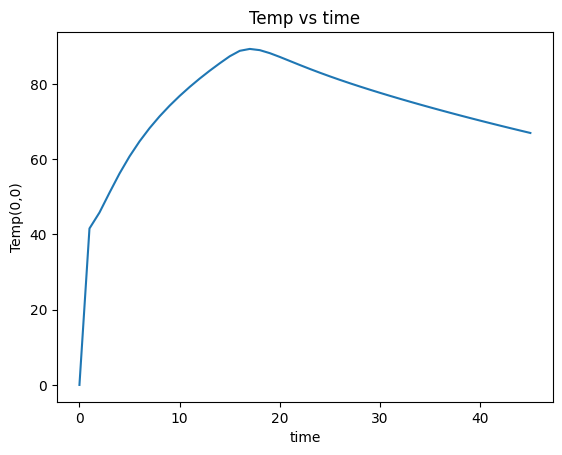

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y1 = u_origin
x = np.arange(0, len(y1))
plt.plot(x, y1, label='y1')  # Line for y1
plt.xlabel('time')
plt.ylabel('Temp(0,0)')
plt.title('Temp vs time')
plt.show()

In [ ]:
!zip -r /content/myfolder3.zip /content/results3
clear_output()